<a href="https://colab.research.google.com/github/pollinations/hive/blob/main/Zero_Shot_Text_Guided_Object_Generation_with_Dream_Fields%2C_lower_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zero-Shot Text-Guided Object Generation with Dream Fields
**By [Ajay Jain](https://ajayj.com/), [Ben Mildenhall](https://bmild.github.io/), [Jonathan T. Barron](https://jonbarron.info/), [Pieter Abbeel](https://people.eecs.berkeley.edu/~pabbeel/), and [Ben Poole](https://cs.stanford.edu/~poole/).**


Website: https://ajayj.com/dreamfields

This notebook demonstrates a scaled down version of Dream Fields, a method for synthesizing 3D objects from natural language descriptions. Dream Fields train a 3D Neural Radiance Field (NeRF) so 2D renderings from any perspective are semantically consistent with a given description. Our loss is based on the OpenAI CLIP text-image model.

If you find this code relevant to your work, please cite our [paper](https://arxiv.org/abs/2112.01455):
```
@article{jain2021dreamfields,
  author = {Jain, Ajay and Mildenhall, Ben and Barron, Jonathan T. and Abbeel, Pieter and Poole, Ben},
  title = {Zero-Shot Text-Guided Object Generation with Dream Fields},
  joural = {arXiv},
  month = {December},
  year = {2021},
}
```

In [10]:
#@title Training hyperparameters
#@markdown More parameters are documented [on GitHub](https://github.com/google-research/google-research/blob/master/dreamfields/dreamfields/config/config_base.py).

#@markdown **Natural language query and seed.**
query = 'melting clocks by salvador dali'  #@param {type:'string'}
seed = 0  #@param {type:'integer'}

#@markdown **CLIP guidance model.** `clip_vit_b16` is suggested.
loss_model = "clip_vit_b16" #@param ["clip_vit_b32", "clip_vit_b16", "clip_resnet_50", "clip_resnet_101", "clip_resnet_50x4"]


#@markdown **Quality settings.** Increase `iters`, `render_width`, `num_samples` or `n_local_aug` for higher quality results, or lower to run faster and reduce memory usage.
iters =   10000#@param {type:'integer'}
config = get_config(iters=iters)
config.render_width = 88  #@param {type:'integer'}
config.crop_width = 80  #@param {type:'integer'}
config.num_samples =   64#@param {type:'integer'}
config.n_local_aug = 7 #@param {type:"slider", min:1, max:32, step:1}
assert config.crop_width <= config.render_width

config.query = query
config.seed = seed
config.loss_model = loss_model

#@markdown **Save memory by recomputation**. These options reduce memory usage but slow down optimization.
config.remat_image_encoder = False #@param {type:"boolean"}
config.remat_mlp = True #@param {type:"boolean"}

#@markdown **Camera sampling.** These define 3D data augs for viewing the scene.
min_zoom = 1.2 #@param {type:"slider", min:1, max:2, step:0.1}
max_zoom = 1.2 #@param {type:"slider", min:1, max:2, step:0.1}
min_elevation = 30 #@param {type:"slider", min:0, max:90, step:1}
max_elevation = 30 #@param {type:"slider", min:0, max:90, step:1}
min_azimuth = 0 #@param {type:"slider", min:0, max:90, step:1}
max_azimuth = 360 #@param {type:"slider", min:0, max:360, step:1}

config.focal_mult_range = [min_zoom, max_zoom]  # Zoom augmentations.
config.th_range = [0, 360]  # Optimize in 360 degrees around object.
config.phi_range = [-max_elevation, -min_elevation]  # Camera elevation, neg degrees above equator.
config.ema_scene_origin = True  # Set to False if object clipped too much.
# Freeze tracked origin initially
config.fix_origin_iters = 200  #@param {type:"integer"}
config.origin_decay = 0.9995  #@param {type:"number"}

#@markdown **Learning rate schedule**. Linear warmup from lr0 to lr1 then linear decay to lr2. Try a higher lr1 if impatient.
lr_warmup_iters = 100  #@param {type:'number'}
config.lr_i_split = lr_warmup_iters
config.lr0 = 1e-5  #@param {type:'number'}
config.lr1 = 5e-4  #@param {type:'number'}
config.lr2 = 1e-4  #@param {type:'number'}

# Reduce size of scene to get away with fewer samples per ray
config.mr0 = 1.
config.mr1 = 1.
# Duration to anneal in transmittance loss.
# Increase if transmittance goes to 1 (empty scene).
config.acc_target_i_split = 100  #@param {type:"integer"}
config.acc_target0 = 0.5
config.acc_target0 = 0.1
# Weight on transmittance loss
config.acc_lam = 0.25

#@markdown **MLP architecture.** Shallower and narrower than in the paper.
residual_blocks = 2 #@param {type:"slider", min:1, max:6, step:1}
min_mlp_width = 128  #@param {type:'number'}
max_mlp_width = 192  #@param {type:'number'}
config.mipnerf.features_early = [min_mlp_width]
config.mipnerf.features_residual = [(max_mlp_width, min_mlp_width)] * residual_blocks
config.mipnerf.features_late = [4]

#@markdown **Coarse to fine**: Integrate positional encoding over larger regions at the start of training. log scale 1 is used in Dream Fields (i.e. no coarse to fine, as in mip-NeRF).
initial_log_posenc_scale = 1 #@param {type:"slider", min:1, max:8, step:0.1}
coarse_to_fine_iters = 1000 #@param {type:"number"}
config.decay_start = initial_log_posenc_scale
config.decay_iters = coarse_to_fine_iters

#@markdown **Logging parameters.** Increase the final render quality here.

# Save model checkpoints
config.checkpoint_every = iters
# Enable low-quality video.
config.render_lq_video = True
config.video_every = iters
config.lq_video_n_frames =   192#@param {type:'integer'}
config.lq_video_width = 512  #@param {type:'integer'}
config.test.num_samples = 128  # Increase if desired to reduce aliasing.
# Disable HQ video.
config.render_hq_video = False
config.hq_video_every = 100000
# Disable validation view rendering.
config.render_every = 100000

timestr = time.strftime('%Y%m%d-%H%M%S')
experiment_dir = f'/content/results/{timestr} {config.query}'
work_unit_dir = f'{experiment_dir}/1'

In [1]:
!pip install --upgrade pip
#!pip install --upgrade jax[cuda] jaxlib -f https://storage.googleapis.com/jax-releases/jax_releases.html
!python -c "print(__import__('jax').local_devices())"


     |████████████████████████████████| 2.1 MB 4.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
[GpuDevice(id=0, process_index=0)]


In [2]:
%cd /content
!git clone https://github.com/google-research/google-research
%cd google-research/dreamfields
#!pip install -r requirements.txt
!pip install clu
!pip install git+git://github.com/voodoohop/scenic.git
!pip install git+https://github.com/openai/CLIP.git
!pip install dm_pix mediapy


import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')


/content
Cloning into 'google-research'...
remote: Enumerating objects: 47900, done.
remote: Counting objects: 100% (7989/7989), done.
remote: Compressing objects: 100% (6063/6063), done.
remote: Total 47900 (delta 1893), reused 7748 (delta 1855), pack-reused 39911
Receiving objects: 100% (47900/47900), 326.76 MiB | 13.82 MiB/s, done.
Resolving deltas: 100% (23801/23801), done.
Checking out files: 100% (13562/13562), done.
/content/google-research/dreamfields
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 KB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.7/176.7 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.3/136.3 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 KB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 KB 10.2 MB/s eta 0:00:00
  Created 

In [3]:
!pwd
%cd /content/google-research/dreamfields/

#import os 
#os.environ['LD_LIBRARY_PATH']='/usr/local/cuda-11.1/lib64:/usr/lib64-nvidia'
#!python run.py --config=dreamfields/config/config_lq.py --query="sleepy bonsai cat"

/content/google-research/dreamfields
/content/google-research/dreamfields


# Install dependencies.
After running, you may need to restart your runtime (Runtime > Restart Runtime).

In [4]:
# Uninstall and reinstall packages to deal with version mismatch
!pip uninstall --yes numpy matplotlib
!pip install --upgrade numpy matplotlib

Found existing installation: numpy 1.21.5
Uninstalling numpy-1.21.5:
  Successfully uninstalled numpy-1.21.5
Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Successfully uninstalled matplotlib-3.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.5/895.5 KB 47.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Imports

In [5]:
# Prevent tensorflow from hogging memory
import tensorflow as tf
tf.config.experimental.set_visible_devices([], "GPU")

In [6]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

import jax
try:
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  default_precision = 'bfloat16'
  use_gpu = False
except KeyError as e:
  print('No TPUs available')
  default_precision = 'tensorfloat32'
  use_gpu = True

print(jax.devices())

if use_gpu:
  !nvidia-smi

env: XLA_PYTHON_CLIENT_PREALLOCATE=false
No TPUs available
[GpuDevice(id=0, process_index=0)]
Sun Feb 20 22:01:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |    257MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+------------------

In [7]:
!pip install tensorflow==2.6.0 keras==2.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.3/458.3 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=92893f934c6d202c75f81b7c75972a124cc76a94ccac3f7a9feeee83bb24069a
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68724 sha256=fee9e2fb563c8a91d274d7f18c894d068734b0e036a1d891895b78e03de49ec5
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built clang wrapt
  Attempting uninstall: wrapt
    Found exist

In [8]:
import collections
from collections import defaultdict
import functools
import os
import random as py_random
import time
from typing import Optional, Sequence

from absl import logging
from clu import metric_writers
import flax 
import flax.linen as nn
from flax.training import checkpoints
from IPython.display import clear_output, display, Image
import jax
import jax.numpy as np
from jax import random
import matplotlib.pyplot as plt
import mediapy as media
import ml_collections
import numpy as onp
from scipy import stats
import tensorflow.io.gfile as gfile
import tqdm

nn.enable_named_call()

In [9]:
from dreamfields import augment
from dreamfields import helpers
from dreamfields import log
from dreamfields import mipnerf
from dreamfields import scene
from dreamfields import schedule
from dreamfields.config.config_mq import get_config

# Configure run

# Set seed

In [11]:
py_random.seed(config.seed * jax.process_count() + jax.process_index())
onp.random.seed(config.seed * jax.process_count() + jax.process_index())
rng = helpers.RngGen(
    jax.random.fold_in(jax.random.PRNGKey(config.seed), jax.process_index()))

# Training code

In [12]:
class MipMLPLate(nn.Module):
  """MLP architecture."""
  activation: str
  features_early: Sequence[int]
  features_residual: Sequence[Sequence[int]]
  features_late: Sequence[int]
  fourfeat: bool
  max_deg: int
  use_cov: bool
  dropout_rate: float
  remat: bool

  @nn.compact
  def __call__(self, mean, cov=None, x_late=None, decayscale=1.,
               *, deterministic):
    """Run MLP."""
    # Integrate the positional encoding over a region centered at mean.
    if not self.fourfeat:
      # Axis-aligned positional encoding.
      feat = 2**np.arange(self.max_deg)[:, None, None] * np.eye(3)
      feat = feat.reshape(-1, 3)
    else:
      # Random Fourier Feature positional encoding. Fix the PRNGKey used for the
      # fourier feature basis so the encoding does not change over iterations.
      fourfeat_key = random.PRNGKey(124124)
      dirs = random.normal(fourfeat_key, (3, 128))
      dirs = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
      rads = 2 ** (self.max_deg * random.uniform(fourfeat_key, (128,)))
      feats = (rads * dirs).astype(np.int32)
      feats = np.concatenate([np.eye(3), feats], 1).astype(np.float32)
      feat = feats.T

    mean_proj = (mean[Ellipsis, None] * feat.T).sum(-2)
    if self.use_cov:
      cov_diag_proj = ((cov[Ellipsis, None] * feat.T).sum(-2) * feat.T).sum(-2)
      decay = np.exp(-.5 * cov_diag_proj * decayscale**2)
    else:
      # Disable IPE
      decay = 1.
    x = np.concatenate([decay * np.cos(mean_proj),
                        decay * np.sin(mean_proj)], -1)

    # Network
    activation = nn.__getattribute__(self.activation)
    if self.remat:
      activation = jax.remat(activation)
    for feat in self.features_early:
      x = activation(nn.Dense(feat)(x))
      x = nn.Dropout(self.dropout_rate)(
          x, deterministic=deterministic)

    for feat_block in self.features_residual:
      norm = nn.LayerNorm()
      if self.remat:
        norm = jax.remat(norm)
      h = norm(x)
      for l, feat in enumerate(feat_block):
        h = nn.Dense(feat)(h)
        h = nn.Dropout(self.dropout_rate)(
            h, deterministic=deterministic)
        if l < len(feat_block) - 1:  # don't activate right before the residual
          h = activation(h)
      x = x + h

    if x_late is not None:
      x = np.concatenate([x, x_late], axis=-1)
    for feat in self.features_late[:-1]:
      x = activation(nn.Dense(feat)(x))
      x = nn.Dropout(self.dropout_rate)(
          x, deterministic=deterministic)
    x = nn.Dense(self.features_late[-1])(x)  # don't activate output
    return x


def init_nerf_model(key, config):
  """Initialize NeRF MLP."""
  if config.parameterization == 'mipnerf':
    model = MipMLPLate(
        activation=config.mlp_activation,
        features_early=config.features_early,
        features_residual=config.features_residual,
        features_late=config.features_late,
        max_deg=config.posenc_deg,
        fourfeat=config.fourfeat,
        use_cov=config.mipnerf.get('use_cov', True),
        dropout_rate=config.mipnerf.get('dropout_rate', 0.),
        remat=config.get('remat_mlp', False))
    if config.viewdirs:
      x_late = scene.posenc(np.zeros([1, 3]), config.posenc_dirs_deg)
    else:
      x_late = None
    variables = model.init(
        key, np.zeros([1, 3]), np.zeros([1, 3, 3]), x_late, deterministic=True)

    render_rays = functools.partial(mipnerf.render_rays_mip, model=model)
  else:
    raise ValueError

  return variables, render_rays


class DreamField:
  """Trainable Dream Field model."""

  def __init__(self, config):
    self.config = config

  def run_train(self,
                experiment_dir,
                work_unit_dir,
                rng: helpers.RngGen,
                yield_results=False):
    """Train a Dream Field and save results to work_unit_dir."""
    t_start = time.time()
    config = self.config

    logging.info('Local devices: %s', jax.local_devices())
    logging.info('All devices: %s', jax.devices())

    ## Load CLIP
    encode_image, encode_text, preprocess_image, tokenize_fn = (
        helpers.load_image_text_model(config.loss_model))

    ## Pick a prompt
    template = config.get('query_template', '{query}')
    query = template.format(query=config.query)
    z_clip = encode_text(tokenize_fn(query))
    del encode_text, tokenize_fn  # Clean up text encoder.

    ## Scene origin manually tracked
    scene_origin = scene.EMA(
        np.zeros(3, dtype=np.float64), decay=config.get('origin_decay', 0.999))

    def train_step(state, rays, key, *multistep_constants):
      """Perform a training iteration, optionally composed of multiple substeps.

      Using multiple substeps slightly reduces training time, but only one
      substep per training iteration is used in experiments.

      Args:
        state: Optimizer state.
        rays: Camera rays for rendering, shared across all substeps.
        key: PRNGKey for random number generation (e.g. for augmentations).
        *multistep_constants: Training constants that can vary across substeps.
          6 arrays of constants of length config.substeps are expected:
            (1) lrs: learning rates
            (2) scs: scale factor for integrated positional encoding. Larger
                scales lead to a blurrier appearance. A constant sc=1 is the
                standard mip-NeRF IPE, and used by Dream Fields.
            (3) sns: standard deviation of pre-activation noise for NeRF
                density. Dream Fields use sn=0.
                  density(x) = softplus(s(x) + eps), eps ~ N(0, sn^2)
            (4) mrs: norm of radiance mask, defining scene bounds.
            (5) acct: transmittance loss hyperparameter, defining the target
                average opacity. This is 1 - tau (target transmittance).
            (6) acclam: weight of transmittance loss.

      Returns:
        state: Updated optimizer state.
        last_augs: Augmented views of renderings from the last substep.
        mean_losses: Dictionary of losses averaged over replicas and substeps.
        scene_origin: Updated origin of the scene, based on the center of mass.
      """
      # NOTE(jainajay): rays are shared across all substeps
      pmean = functools.partial(jax.lax.pmean, axis_name='batch')
      psum = functools.partial(jax.lax.psum, axis_name='batch')

      def loss_fn(params, key, sc, sn, mr, acct, acclam):
        render_key, aug_key, key = random.split(key, 3)

        # Render from nerf
        (rgb_est_flat, _, acc_est_flat), aux = render_rays(
            rays=rays,
            variables=params,
            rng=render_key,
            config=config,
            sc=sc,
            sigma_noise_std=sn,
            mask_rad=mr,
            origin=scene_origin.value,
            train=True)
        rgb_est = scene.gather_and_reshape(rgb_est_flat, config.render_width, 3)
        acc_est = scene.gather_and_reshape(acc_est_flat, config.render_width, 1)
        # Make augmentations process specific
        aug_key = random.fold_in(aug_key, pid)
        # Perform augmentations and resize to clip_width
        augs = augment.augment_rendering(config, rgb_est, acc_est, aug_key)

        # Run through CLIP
        augs_pre = preprocess_image(augs)
        with jax.default_matmul_precision(default_precision):
          if config.get('remat_image_encoder', False):
            z_est = jax.remat(encode_image)(augs_pre)
          else:
            z_est = encode_image(augs_pre)
        clip_loss = -(z_est * z_clip).sum(-1).mean()
        total_loss = clip_loss

        transparency_loss = config.get('transparency_loss', None)
        acc_mean = np.mean(acc_est)
        aux['losses']['acc_mean'] = acc_mean
        if transparency_loss == 'neg_lam_transmittance_clipped':
          # Compute the Dream Fields transmittance loss for scene sparsity.
          trans_mean = 1 - acc_mean
          trans_mean_clipped = np.minimum(1 - acct, trans_mean)
          reg = acclam * trans_mean_clipped
          total_loss -= reg

          aux['losses']['trans_mean_clipped'] = trans_mean_clipped
          aux['losses']['acc_reg_additive'] = reg
        else:
          assert transparency_loss is None

        # Compute a weighted mean of each replica's estimated scene origin,
        # since replicas get a different subset of rays
        total_sigma = psum(aux['scene_origin_sigma'])
        aux['scene_origin'] = psum(aux['scene_origin'] *
                                   aux['scene_origin_sigma'] / total_sigma)

        aux['losses'].update({
            'clip_loss': clip_loss,
            'loss': total_loss,
        })
        aux['augs'] = augs
        return total_loss, aux

      grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

      # Scan over substeps
      def body_fn(state, step_constants):
        lr, step_constants = step_constants[0], step_constants[1:]
        grad_fn_key, _ = random.split(key, 2)
        (_, aux), grad = grad_fn(state.target, grad_fn_key, *step_constants)
        grad = pmean(grad)  # all-reduce grad
        aux['losses'] = pmean(aux['losses'])
        aux['losses']['grad_norm'] = helpers.tree_norm(grad)
        state = state.apply_gradient(grad, learning_rate=lr)
        return state, aux

      assert len(multistep_constants) == 6
      multistep_constants = np.array(multistep_constants).T

      if config.substeps == 1:
        state, aux = body_fn(state, np.squeeze(multistep_constants))
        last_augs = aux['augs']
      else:
        state, aux = jax.lax.scan(body_fn, state, multistep_constants)
        # Augmentations from last substep.
        # Shape: [n_local_aug, clip_width, clip_width, 3]
        last_augs = aux['augs'][-1]

      # Average each type of loss over substeps
      mean_losses = jax.tree_map(np.mean, aux['losses'])
      return state, last_augs, mean_losses, aux['scene_origin']

    train_pstep = jax.pmap(
        train_step,
        axis_name='batch',
        in_axes=(0, 0, 0, None, None, None, None, None, None))

    onp.random.seed(config.seed)

    n_device = jax.local_device_count()
    pid = jax.process_index()
    logging.info('n_device %d', n_device)
    ## Modified NeRF architecture, with swish, softplus, skips.
    variables, render_rays = init_nerf_model(rng.advance(1), config)
    state = flax.optim.Adam(config.lr0, eps=config.adam_eps).create(variables)

    ## Try to restore a checkpoint.
    restore_dir = config.get('restore_dir', experiment_dir)
    restore_dir = os.path.join(restore_dir, os.path.basename(work_unit_dir))
    if checkpoints.latest_checkpoint(restore_dir):
      restored = checkpoints.restore_checkpoint(
          restore_dir,
          target={
              'origin': np.zeros(3),
              'state': state,
              'vars': variables
          })
      scene_origin.value = onp.array(restored['origin'])
      state = restored['state']
      variables = restored['vars']
      logging.info('restored checkpoint from step %d', state.state.step)
    else:
      logging.info('did not find checkpoint in %s', restore_dir)

    ## Replicate state.
    step_init = state.state.step
    helpers.defragment()
    state = flax.jax_utils.replicate(state, jax.devices())
    helpers.defragment()

    ## pmap'd rendering for test time evaluation.
    kwargs_test = dict(rng=None, sigma_noise_std=0.)
    config_test = ml_collections.ConfigDict(config)
    config_test.update(config.test)

    @functools.partial(jax.pmap, in_axes=(0, None, None, None))
    def render_test_p(rays, variables, sc=1., mr=1.):
      return render_rays(
          rays=rays,
          variables=variables,
          sc=sc,
          mask_rad=mr,
          origin=scene_origin.value,
          config=config_test,
          **kwargs_test)[0]

    def render_test(rays, variables, sc=1., mr=1.):
      sh = rays[0].shape
      rays = [x.reshape((jax.device_count(), -1) + x.shape[1:]) for x in rays]
      out = render_test_p(rays, variables, sc, mr)
      out = [x.reshape(sh[:-1] + (-1,)) for x in out]
      return out

    def render_loop(rays, variables, sc=1., mr=1., chunk=2**13):
      sh = list(rays[0].shape[:-1])
      rays = [x.reshape((-1,) + x.shape[-1:]) for x in rays]
      outs = [
          render_test([x[i:i + chunk]
                       for x in rays], variables, sc, mr)
          for i in range(0, rays[0].shape[0], chunk)
      ]
      outs = [
          np.reshape(np.concatenate([z[i]
                                     for z in outs]), sh + [-1])
          for i in range(3)
      ]
      return outs

    ## Training loop
    t_total = 0.
    logging.info('Experiment dir %s', experiment_dir)
    logging.info('Work unit dir %s', work_unit_dir)
    gfile.makedirs(work_unit_dir)

    if jax.process_index() == 0:
      train_config = config.copy_and_resolve_references()
      log.write_config_json(train_config, work_unit_dir)

    # Scale instrinsics to different resolutions.
    hwf_clip_r = scene.scale_intrinsics(config.retrieve_widths[0])
    hwf_base = scene.scale_intrinsics(config.render_width)
    hwf_video = scene.scale_intrinsics(config.get('lq_video_width', 300.))
    hwf_video_hq = scene.scale_intrinsics(config.get('hq_video_width', 400.))

    # JIT compile ray generation
    @jax.jit
    def camera_ray_batch_base(p, focal_mult):
      return scene.camera_ray_batch(p, *hwf_base[:2], hwf_base[2] * focal_mult)

    @jax.jit
    def sample_pose_focal(key):
      return scene.sample_camera(key, config.th_range, config.phi_range,
                                 config.rad_range, config.focal_mult_range)

    shard_rays_jit = jax.jit(functools.partial(scene.shard_rays))

    def sample_iter_data(key, step):
      # Sample pose, focal length multiplier.
      pose, rad, focal_mult = sample_pose_focal(key)

      # Generate rays, shaped for pmap over devices.
      rays = camera_ray_batch_base(pose, focal_mult)
      rays_in = shard_rays_jit(rays)
      # Select rays for this process
      rays_in = jax.tree_map(lambda x: x[pid], rays_in)

      substeps = np.arange(start=step, stop=step + config.substeps, step=1)

      # mip-NeRF scale annealing.
      decays = config.mipnerf.decay_start * (
          1 - substeps / config.mipnerf.decay_iters)
      scs = np.maximum(1., 2**decays)

      # Sigma noise annealing.
      sns = schedule.sigma_noise_std_fn(
          substeps, i_split=config.sn_i_split, sn0=config.sn0, sn1=config.sn1)

      # Scene bounds annealing.
      mrs = schedule.mask_rad_fn(
          substeps, i_split=config.mr_i_split, mr0=config.mr0, mr1=config.mr1)

      # Anneal target opacity (1 - transmittance).
      accts = schedule.anneal_exponentially(substeps, config.acc_target_i_split,
                                            config.acc_target0,
                                            config.acc_target1)
      # The area of an object on the image plane grows with the focal length
      # and shrinks with increasing camera radius. Scale target opacity
      # proportionally with the squared focal multiplier and inversely
      # proportionally with the squared camera radius. For consistency with
      # early experiments that did not use this scaling, we also scale by a
      # constant, 1 / (4^2 * 1.2).
      acct_scaling = focal_mult**2 / ((rad / 4.)**2) / 1.2
      accts = np.minimum(1., acct_scaling * accts)
      acclams = np.where(substeps < config.acc_lam_after, 0., config.acc_lam)

      # Learning rate schedule.
      # NOTE: vectorized calculation of lrs doesn't work with multiple substeps
      lrs = schedule.lr_fn(
          substeps,
          i_split=config.lr_i_split,
          i_end=config.iters,
          lr0=config.lr0,
          lr1=config.lr1,
          lr2=config.lr2,
          cosine_decay=config.lr_cosine_decay)

      return substeps, rays_in, lrs, scs, sns, mrs, accts, acclams

    pbar = tqdm.trange(
        step_init,
        config.iters + config.substeps,
        config.substeps,
        desc='training')
    for i in pbar:
      substeps, rays_in, lrs, scs, sns, mrs, accts, acclams = (
          sample_iter_data(rng.advance(1), i))
      l = substeps[-1]

      keys_pstep = rng.split(n_device)
      # NOTE: loss is averaged across substeps.
      new_state, augs, mean_losses, new_scene_origin = train_pstep(
          state, rays_in, keys_pstep, lrs, scs, sns, mrs, accts, acclams)

      # Reduce across devices
      mean_losses = jax.tree_map(np.mean, mean_losses)

      # Gradient skipping if nan.
      if (helpers.all_finite_tree(mean_losses) and
          helpers.all_finite_tree(new_state)):
        state = new_state
      else:
        logging.warn('Skipping update on step %d. non-finite loss or state', i)
        continue

      # Update scene origin.
      if (config.get('ema_scene_origin', False) and
          l > config.get('fix_origin_iters', -1)):
        if helpers.all_finite(new_scene_origin):
          scene_origin.update(new_scene_origin[0])
        else:
          logging.warn(
              'Skipping origin update on step %d. '
              'non-finite origin. old: %s skipped update: %s', i,
              scene_origin.value, new_scene_origin)

      ## Yield results, for display in colab.
      augs = augs.reshape(-1, *augs.shape[2:])  # devices, n_localaug, HWC->BHWC
      if yield_results:
        yield mean_losses, augs, scene_origin.value, lrs[-1]
      else:
        yield None
      pbar.set_description(f'CLIP loss: {mean_losses["clip_loss"]:.4f}')

      ## Logging.
      if i == 0:
        continue

      if i % config.render_every == 0:
        variables = helpers.state_to_variables(state)
        cam2world = scene.pose_spherical(30., -45., 4.)
        rays = scene.camera_ray_batch(cam2world, *hwf_clip_r)

        # Render with no scale manipulation.
        outs = render_loop(rays, variables, sc=1., mr=mrs[-1], hq=True)
        outs = [np.squeeze(x) for x in outs]
        step_images = {
            'render/rgb': outs[0][None],
            'render/depth': outs[1][None, ..., None],
            'render/acc': outs[2][None, ..., None],
            'render/augmentations': log.make_image_grid(augs[:8])
        }

        fig = plt.figure()
        plt.imshow(1. / np.maximum(config.near, outs[1]))
        plt.colorbar()
        plt.title('disparity')
        disparity = log.plot_to_image(fig)
        step_images['render/disparity'] = disparity

      if config.render_lq_video and (i == config.iters or
          config.video_every and i % config.video_every == 0):
        def rays_theta(th):
          cam2world = scene.pose_spherical(th, -30., 4.)
          return scene.camera_ray_batch(cam2world, *hwf_video)

        th_range = np.linspace(
            0, 360, config.get('lq_video_n_frames', 60), endpoint=False)
        variables = helpers.state_to_variables(state)
        frames_all = [
            render_loop(rays_theta(th), variables, scs[-1], mrs[-1])
            for th in tqdm.tqdm(th_range, desc='render video')
        ]

        videos = [[np.squeeze(f[i]) for f in frames_all] for i in range(3)]
        for video, label in zip(videos, 'rgb depth acc'.split()):
          scale = (label == 'depth')
          log.log_video(
              None, video, 'frames', label, l, work_unit_dir, scale=scale)

      defrag_every = config.get('defragment_every', default=0)
      if defrag_every and i % defrag_every == 0:
        helpers.defragment()

      if config.get('checkpoint_every') and i % config.checkpoint_every == 0:
        saved_path = checkpoints.save_checkpoint(
            ckpt_dir=work_unit_dir,
            target={
                'state': flax.jax_utils.unreplicate(state),
                'vars': helpers.state_to_variables(state),
                'origin': np.array(scene_origin.value),
            },
            step=l,
            keep=1,
            overwrite=True,
            keep_every_n_steps=config.get('keep_every_n_steps', None))
        logging.info('saved checkpoint to %s', saved_path)

# Visualization helpers

In [13]:
def show_videos(work_unit_dir, title):
  video_iters = config.iters
  fps = config.lq_video_n_frames / 2
  media.show_video(onp.concatenate([
      media.read_video(os.path.join(work_unit_dir, f'frames_rgb_{video_iters:05d}.mp4')),
      media.read_video(os.path.join(work_unit_dir, f'frames_acc_{video_iters:05d}.mp4')),
      media.read_video(os.path.join(work_unit_dir, f'frames_depth_{video_iters:05d}.mp4')),
  ], axis=2), title=title, fps=fps)


def plot_losses(losses, log_interval=1):
  steps = np.arange(len(losses['loss'])) * log_interval

  keys = {
    'loss': 'Total loss',
    'clip_loss': 'CLIP negative cosine sim',
    'grad_norm': 'Gradient norm',
    'acc_mean': 'Avg transmittance',
    'origin_norm': 'Origin drift',
    'learning_rate': 'Learning rate',
  }

  _, axes = plt.subplots(1, len(keys), figsize=(len(losses) * 3, 3))
  for i, (key, label) in enumerate(keys.items()):
    axes[i].set_title(label)
    values = onp.array(losses[key])
    if key == 'acc_mean':
      values = 1 - values  # Opacity to transmittance
    axes[i].plot(steps, values)
    if key in ('grad_norm', 'learning_rate'):
      axes[i].set_yscale('log')
  plt.tight_layout()
  plt.show()


def show_image_row(augs):
  A, H, W, C = augs.shape
  augs = augs.transpose(1, 0, 2, 3)
  augs = augs.reshape((H, A*W, C))

  plt.figure(figsize=(8*A, 8))
  plt.imshow(augs)
  plt.show()


def show_image_grid(images, ncol=8):
  """Plot a grid of images."""
  images_stacked = onp.array(images)
  T = len(images)
  nrow = int(onp.ceil(T / ncol))
  H, W, C = images[0].shape
  dtype = images[0].dtype

  canvas = onp.zeros((H*nrow, W*ncol, C), dtype=dtype)
  for i, image in enumerate(images):
    row, col = i // ncol, i % ncol
    canvas[row*H:row*H+H, col*W:col*W+W, :] = image

  plt.figure(figsize=(2*ncol, 2*nrow))
  plt.imshow(canvas)
  plt.show()

In [14]:
!pip uninstall -y matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Successfully uninstalled matplotlib-3.5.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 77.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Run training
100-200 iterations may be required before the scene begins to fill with visible content.

The above configuration should work with 15 GB of GPU memory (e.g. Tesla T4). **If you run out of memory, tweak the configuration options above.** For example, try:
*   num_samples = 48
*   n_local_aug = 3

You can also try scaling up parameters like resolution and n_local_aug for improved quality.

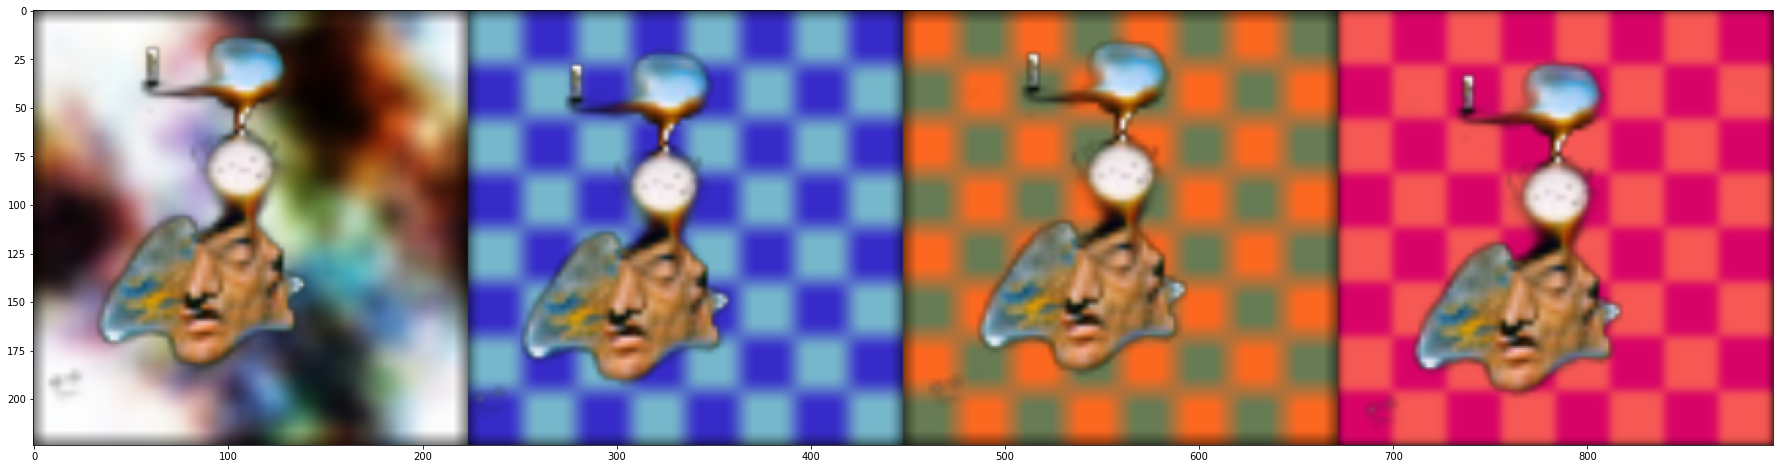

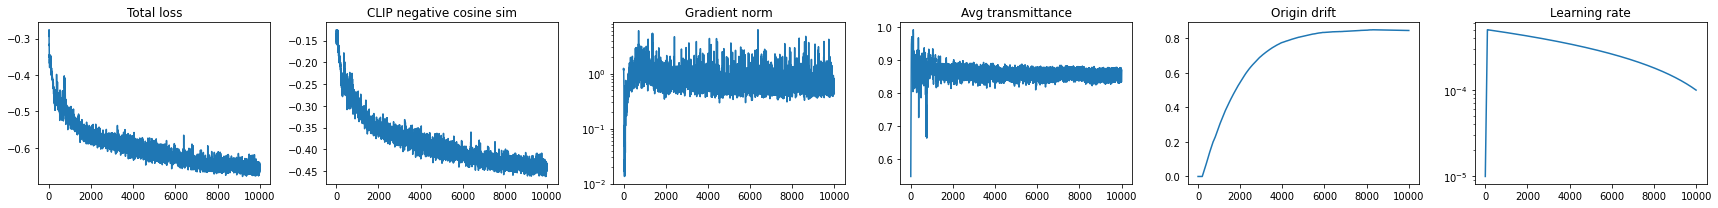

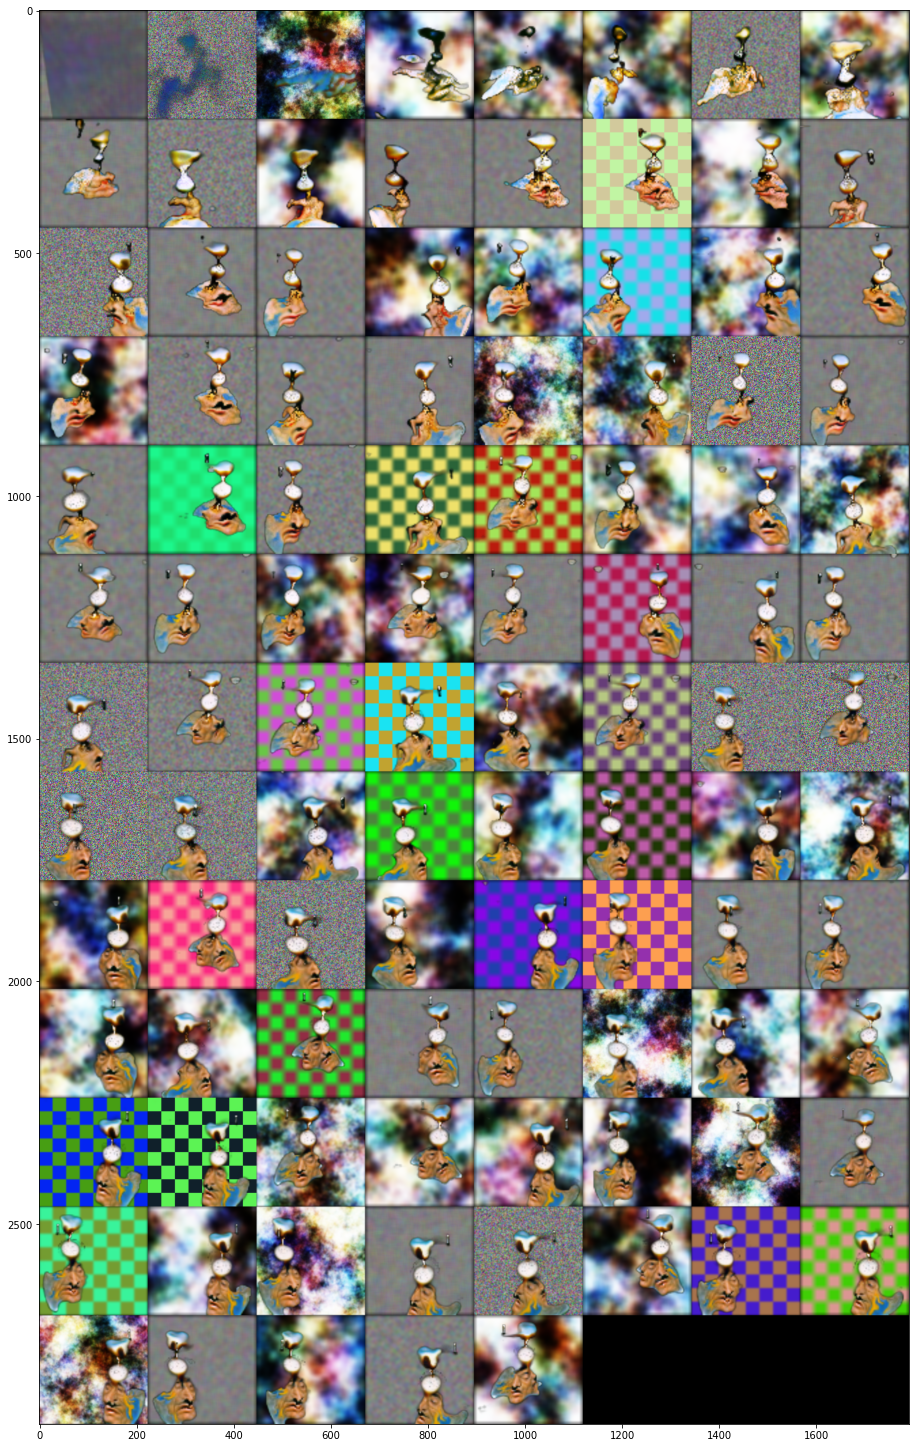

Sun Feb 20 23:36:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    49W / 250W |  16123MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

CLIP loss: -0.4498: 100%|█████████▉| 10000/10001 [1:35:12<00:00,  1.75it/s]


ValueError: ignored

In [15]:
if use_gpu:
  # Monitor memory usage
  !nvidia-smi

import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

model = DreamField(config)
losses = defaultdict(list)
images = []
log_interval = 2
for step, (loss, image, origin, lr) in enumerate(model.run_train(
    experiment_dir=experiment_dir, work_unit_dir=work_unit_dir, rng=rng,
    yield_results=True)):
  
  if step % log_interval == 0:
    losses['origin_norm'].append(np.sqrt(np.sum(np.square(origin))))
    for key, value in loss.items():
      losses[key].append(value)
    losses['learning_rate'].append(lr)

  if step % 25 == 0:
    clear_output(wait=True)
    show_image_row(image[:4])  # display up to 4 current augs
    plot_losses(losses, log_interval)

    # Plot past renders
    images.append(image[0])  # limit to 1 aug for history
    show_image_grid(images)

    if use_gpu:
      # Monitor memory usage
      !nvidia-smi

    if step % 100 != 0:
      # Remove last iter's render so we don't plot too much
      images.pop()

In [ ]:
show_videos(work_unit_dir, title=config.query)